# Introduction au modèle d'Ising

Le [modèle d'Ising](https://fr.wikipedia.org/wiki/Mod%C3%A8le_d%27Ising) est un modèle qui permet d'expliquer les phénomènes d'interactions locales entre particules. On pourra notamment citer les phénomènes d'alignement de spins dans les matériaux ferro-magnétiques. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

## Définition du problème

On se place dans le cas d'un système de particules réparties sur une grille de taille données. Les particules ont un spin (1 ou -1) et n'interagissent qu'avec les particules immédiatement situées à leur droite ou à leur gauche.

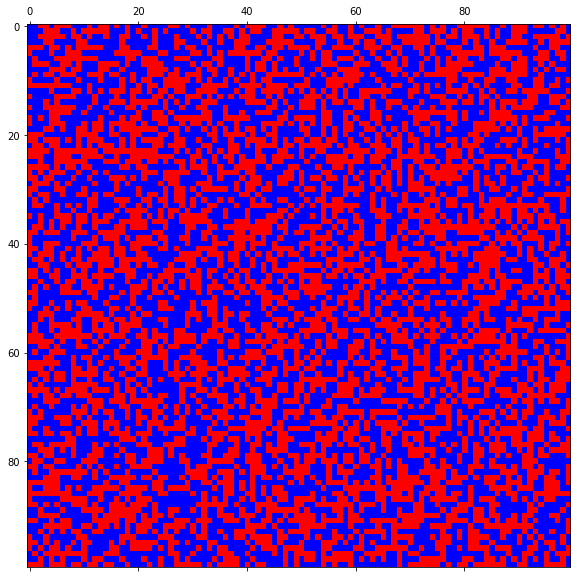

In [2]:


def initialize_grid(grid_width=100, grid_height=100):
    return np.random.choice([1, -1], size=(grid_height, grid_width))



grid = initialize_grid()

def plot_grid(grid):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(grid, cmap='bwr')
    plt.show()
    
plot_grid(grid)

## Calcul de l'énergie du système

Le modèle d'Ising propose d'estimer l'énergie du système, en prenant la formule suivante:

$ H = - \sum_{i, j} J_{i, j}\sigma_i\sigma_j - h \sum_i \sigma_i$

Comment lire cette formule: 

* $\sigma_i$ représente le spin de la particule $i$
* $J_{i, j}$ est un terme d'interactions en les particules $i$ et $j$
* $h$ est un terme représentant l'énergie associées à un spin.

On estime que les interactions ne concernent que les 4 plus proches voisins d'une particule:

$ J_{i, j} \neq 0 \text{ si et seulement si } |i-j| \le 1$

On peut ensuite estimer que $J$ a une valeur constante.

On se ramène ainsi à l'équation suivante:

$ H = -J\sum_{i, j, |i-j| = 1}\sigma_i\sigma_j - h \sum_i \sigma_i$

ou encore

$ H = -J\sum_{i}\sigma_i\sum_{j, |i-j| = 1}\sigma_j - h \sum_i \sigma_i$

Le premier terme peut donc être retrouvé par une convolution avec un filtre bien choisi, multiplié par la grille de départ.

In [3]:
from scipy.signal import convolve

def compute_system_energy(grid, J=1, h=0):
    interaction_filter = np.zeros(shape=(3, 3))
    interaction_filter[1, :] = 1
    interaction_filter[:, 1] = 1
    interaction_filter[1, 1] = 0


    H = - J * (convolve(grid, interaction_filter, mode='same') * grid).sum() - h * grid.sum()
    return H

## Méthode de Monte Carlo

Pour trouver l'évolution du système vers un état d'équilibre à une température donnée, on peut utiliser une méthode de Monte Carlo:
Tant que le système n'arrive pas à un état d'équilibre:

1. Tirer une modification aléatoire tranformant le système $M_i$ en $M_{i+1}$
2. Calculer l'énergie du nouveau système  $E_{i+1}$ à partir de la formule calculée précédemment
3. Si $\Delta E_{i+i} = E_{i+1} - E_{i} < 0$ alors le système est plus stable et la modification est acceptée
3. Si $\Delta E_{i+i} = E_{i+1} - E_{i} > 0$ alors le système est moins stable et la modification est acceptée avec une probabilité $P=e^{-\frac{\Delta E_{i+1}}{k_BT}}$ avec $T$ la temperature du système et $k_B$ la constante de Boltzman prise égale à 1.

Dans un premier temps, on pourra considère que la modification correspond à l'inversement d'un spin.

In [4]:
def compute_probability(T=10, delta_E=0, k_b=1):
    return np.exp(delta_E / (k_b * T))

In [5]:
def compute_monte_carlo1(grid, T=100, J=1, h=0, k_b=1, n_steps=1000):
    energies = []
    
    for i in tqdm(range(n_steps)):
        energy = compute_system_energy(grid, J=J, h=h)

        modification_i = np.random.randint(grid.shape[0])
        modification_j = np.random.randint(grid.shape[1])

        new_grid = grid.copy()
        new_grid[modification_i, modification_j] *= -1

        new_energy = compute_system_energy(new_grid, J=J, h=h)

        delta_energy = new_energy - energy

        if (
            (delta_energy < 0) or
            (np.random.uniform() > compute_probability(T=T, delta_E=delta_energy, k_b=k_b))
        ):
            grid = new_grid
            enery = new_energy
        energies.append(energy)
    
    return grid, energies

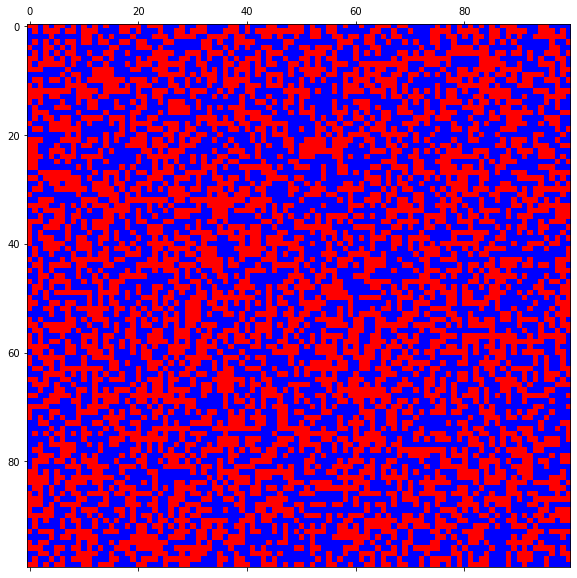

  2%|▏         | 1959/100000 [00:03<02:35, 629.89it/s]


KeyboardInterrupt: 

In [6]:
grid = initialize_grid()

plot_grid(grid)

new_grid, energies = compute_monte_carlo1(grid=grid, n_steps=100000)

plot_grid(new_grid)


plt.figure(figsize=(20, 10))
plt.plot(energies, c='r')
plt.show()

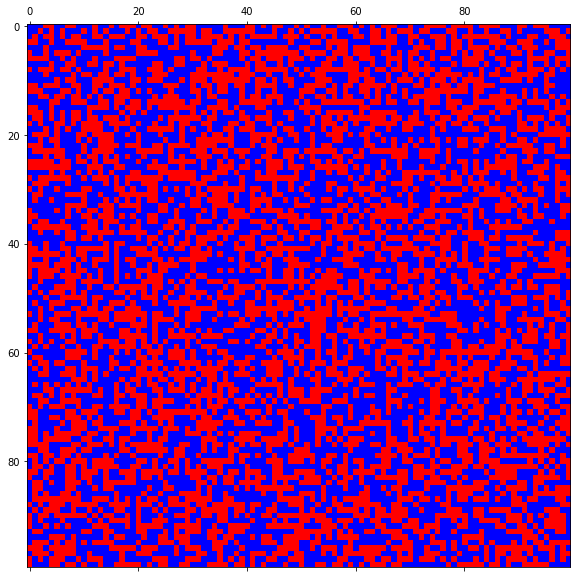

100%|██████████| 5000/5000 [00:06<00:00, 749.38it/s]


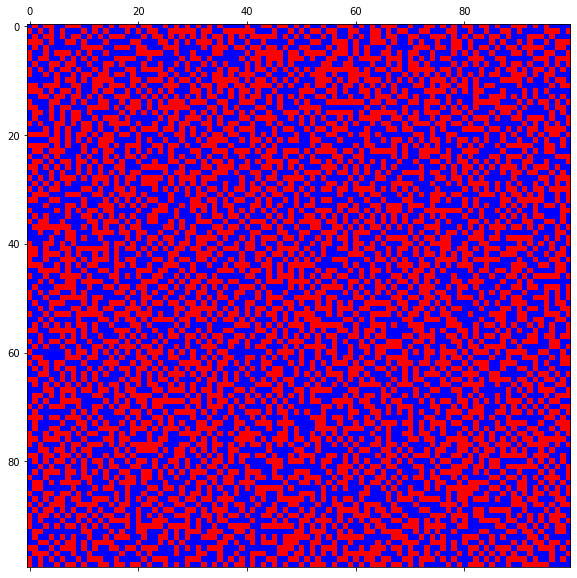

In [7]:
grid = initialize_grid()

plot_grid(grid)

new_grid, energies = compute_monte_carlo1(grid=grid, n_steps=5000, J=-1)

plot_grid(new_grid)

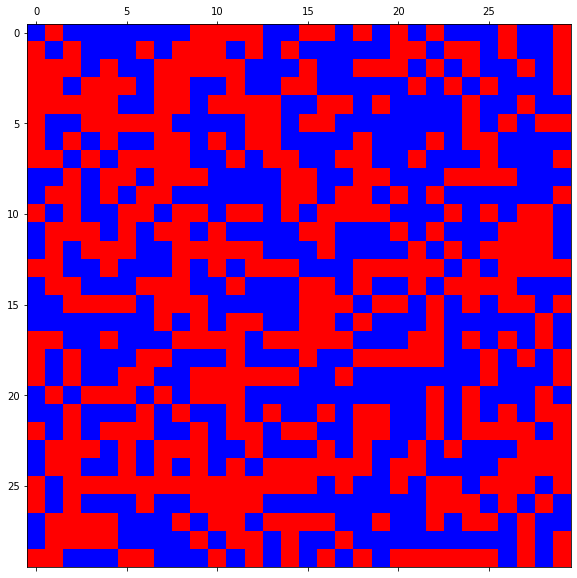

100%|██████████| 10000/10000 [00:04<00:00, 2457.30it/s]


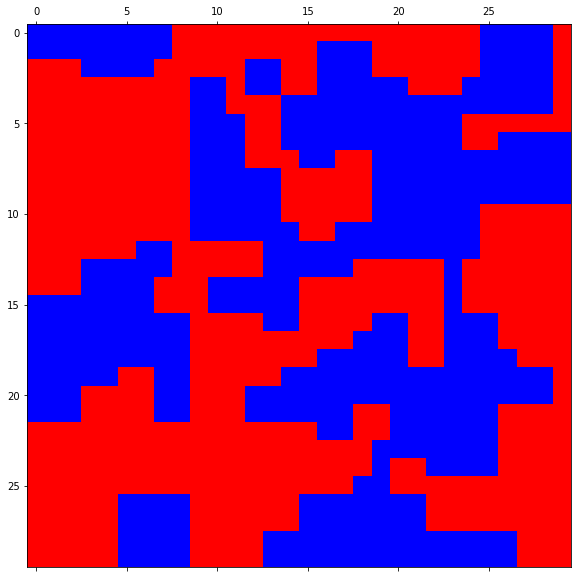

In [8]:
grid = initialize_grid(30, 30)

plot_grid(grid)

new_grid, energies = compute_monte_carlo1(grid, n_steps=10000, J=10)

plot_grid(new_grid)

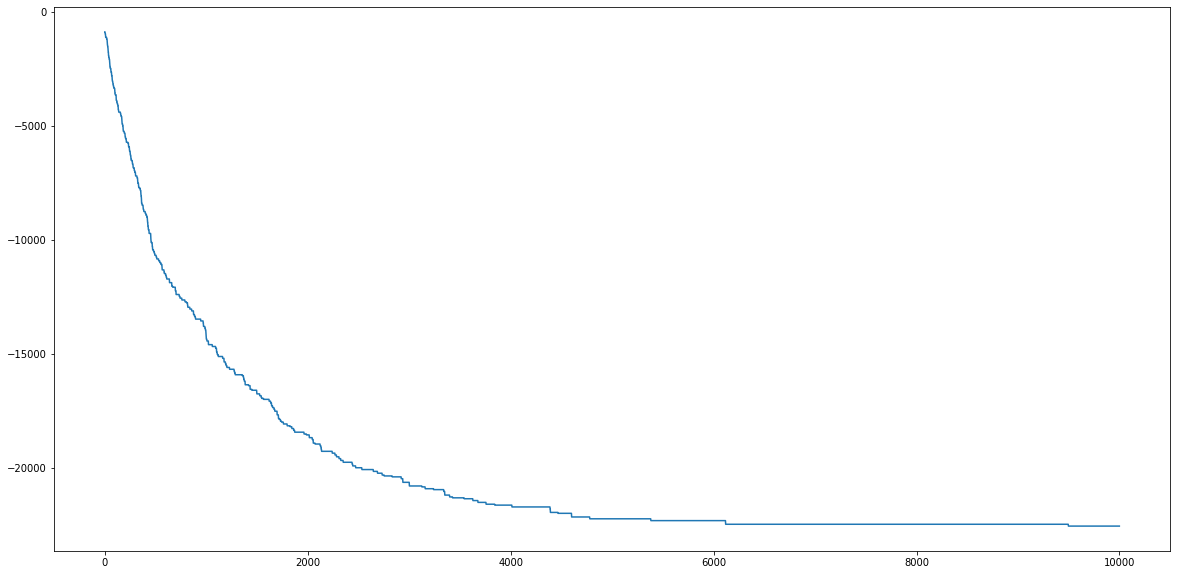